In [63]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from read_ap import read_qrels

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/choenes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/choenes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
all_queries = list(range(1,150))
test_queries = list(range(101,150))
validation_queries = list(range(76,101))


vec_models = ['word2vec', 'doc2vec']
dimension_params = [200, 300, 400, 500]
window_params = [5, 10, 15, 20]
vocab_params = ['10k', '25k', '50k', '100k', '200k']

topic_models = ['lsi_bow', 'lsi_tfidf', 'lda']
topic_params = [10, 20, 50, 100, 500, 1000, 2000]

In [17]:
def load_performance(json_path):
    with open(json_path) as json_file:
        data = json.load(json_file)
    results = defaultdict(list)
    aggregates = {}
    for q in data:
        results['all_map'].append(data[str(q)]["map"])
        results['all_ndcg'].append(data[str(q)]["ndcg"])
        if int(q) in validation_queries:
            results['valid_map'].append(data[str(q)]["map"])
            results['valid_ndcg'].append(data[str(q)]["ndcg"])
        if int(q) in test_queries:
            results['test_map'].append(data[str(q)]["map"])
            results['test_ndcg'].append(data[str(q)]["ndcg"])
    for k in results:
        aggregates[k] = sum(results[k])/len(results[k])
    return aggregates
        

In [54]:
performance_dict_default = {}
topic_models= ['lsi_bow'] # overshadows real value (comment out if json ready)
for model in topic_models:
    json_name = "./"+ model + "500.json"
    aggregates = load_performance(json_name)
    performance_dict_default[model] = aggregates
    print(model)
    for k in aggregates:
        print(f"\t - {k} ---> {aggregates[k]}")

lsi_bow
	 - all_map ---> 0.08339082632172119
	 - all_ndcg ---> 0.4560114300809156
	 - test_map ---> 0.05985849422643051
	 - test_ndcg ---> 0.4315587079506092
	 - valid_map ---> 0.05671283986032173
	 - valid_ndcg ---> 0.42209989759429545


In [49]:
def plot_finetuning(model, configs, x_labels):
    fig, axs = plt.subplots(1, len(configs))
    if len(configs) == 1:
        axs = [axs]
    for col, params in enumerate(configs):
        all_y = []
        test_y = []
        for value in params:
            json_name = "./"+ model + str(value) + ".json"
            aggregates = load_performance(json_name)
            all_y.append(aggregates['all_map'])
            test_y.append(aggregates['test_map'])
        axs[col].plot(params, all_y, label='all queries')
        axs[col].plot(params, test_y, label='test queries')
        axs[col].set_ylabel('MAP', fontsize=16)
        axs[col].set_xlabel(x_labels[col], fontsize=16)
        axs[col].tick_params(axis='both', which='major', labelsize=13)
        axs[col].legend()        
        
    fig.tight_layout()
    plt.show()

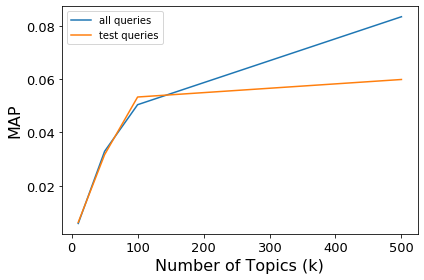

In [50]:
plot_finetuning('lsi_bow', [[10,50,100,500]], ["Number of Topics (k)"])

In [61]:
def get_top_flop_queries(json_path, num_top_flop=1):
    with open(json_path) as json_file:
        data = json.load(json_file)
    data = [(k, v['map']) for k, v in data.items()]
    data.sort(key= lambda t: -t[1])
    return data[:num_top_flop], data[-num_top_flop:]

In [66]:
top, flop = get_top_flop_queries("lsi_bow500.json", 5)
print("top: ", top)
print("flop: ", flop)

top:  [('173', 0.6351959849591148), ('99', 0.5254141189760588), ('164', 0.49992797517041465), ('154', 0.4968736706987605), ('163', 0.48821741120233253)]
flop:  [('149', 0.0007704913443466533), ('117', 0.000770153844490891), ('97', 0.0004766997900708516), ('105', 0.0004357445714320897), ('112', 0.0003655504544701231)]


In [67]:
qrels, queries = read_qrels()
print("Top queries:")
for qid, Map in top:
    print("\t - "+queries[qid])
print("Flop queries:")
for qid, Map in flop:
    print("\t - "+queries[qid])

Top queries:
	 -   Smoking Bans 

	 -   Iran-Contra Affair 

	 -   Generic Drugs - Illegal Activities by Manufacturers 

	 -   Oil Spills 

	 -   Vietnam Veterans and Agent Orange 

Flop queries:
	 -   Industrial Espionage 

	 -   Capacity of the U.S. Cellular Telephone Network 

	 -   Fiber Optics Applications 

	 -   "Black Monday" 

	 -   Funding Biotechnology 



In [73]:
def map_variance_over_models(json_files, top_num=5):
    query_variances = {}
    data = {}
    map_per_query = defaultdict(list)
    for i, file in enumerate(json_files):
        with open(file) as json_file:
            data[i] = json.load(json_file)
    for query in data[0]:
        for model in range(len(json_files)):
            map_per_query[query].append(data[model][query]['map'])
    for k in map_per_query:
        query_variances[k] = np.var(map_per_query[k])
    query_variances = [(k, v) for k, v in query_variances.items()]
    query_variances.sort(key= lambda t: -t[1])
    return query_variances[:top_num]

In [74]:
top_var = map_variance_over_models(["lsi_bow10.json", "lsi_bow50.json", "lsi_bow100.json", "lsi_bow500.json"], top_num=5)
print(top_var)

[('173', 0.0720320182686526), ('163', 0.04405405231815694), ('154', 0.0377662024235386), ('70', 0.034047522203259836), ('164', 0.03337039087418893)]


In [75]:
print("Highest variance:")
for qid, Map in top_var:
    print("\t - "+queries[qid])

Highest variance:
	 -   Smoking Bans 

	 -   Vietnam Veterans and Agent Orange 

	 -   Oil Spills 

	 -   Surrogate Motherhood 

	 -   Generic Drugs - Illegal Activities by Manufacturers 

